# Сборный проект-2. Прогнозирование удовлетворенности и увольнения сотрудников.

Для того, чтобы избежать финансовых потерь и оттока сотрудников, HR-аналитики компании «Работа с заботой» делают ставку на машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Нам предстоит решить две задачи:
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Импортируем необходимые библиотеки.**

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import phik
warnings.filterwarnings('ignore')

**Объявляем нужные переменные.**

In [3]:
RANDOM_STATE = 29

## Шаг 1. Загрузка данных

In [4]:
try:
    job_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    features = pd.read_csv('/datasets/test_features.csv')
    target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    print('Возникла ошибка загрузки данных')

## Шаг 2. Предобработка данных

In [5]:
job_satisfaction.info()
job_satisfaction.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [6]:
job_satisfaction[job_satisfaction['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [7]:
job_satisfaction[job_satisfaction['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [8]:
cat_columns = job_satisfaction.select_dtypes(include='object').columns.tolist()
num_columns = job_satisfaction.select_dtypes(include='int').columns.tolist()

In [9]:
for column in cat_columns:
    print(job_satisfaction[column].unique())
print('Количество явных дубликатов:', job_satisfaction.duplicated().sum())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']
Количество явных дубликатов: 0


In [10]:
features.info()
for column in cat_columns:
    print(features[column].unique())
print('Количество явных дубликатов:', features.duplicated().sum())
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']
Количество явных дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


**Найдены пробелы в столбцах `dept` и `workload`. Заменим их пустыми значениями, а потом обработаем в пайплайне.**

In [11]:
features['dept'] = features['dept'].replace(' ', np.nan)
features['workload'] = features['workload'].replace(' ', np.nan)

In [12]:
target.info()
print('Количество явных дубликатов:', target.duplicated().sum())
target.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
Количество явных дубликатов: 0


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


**Явных дубликатов нет, неявных тоже. Есть только пропуски в значениях: в столбце `dept` и в столбце `level` в тренировочном датасете и в таблице с входными признаками. Заполним пропуски модальными значениями в пайплайне. Заметил, что данные в тестовых датасетах не отсортированы. В таком виде, для расчета метрики качества модели, их брать нельзя. Тут я их объединю в один датафрейм, а затем, разделю их. Наверное, было бы достаточно просто отсортировать обе таблицы по `id`, но сделал так.**

In [13]:
df_test = features.merge(target, on='id', how='left')
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [14]:
job_satisfaction = job_satisfaction.set_index('id')
df_test = df_test.set_index('id')
all_num_columns = job_satisfaction.select_dtypes(exclude='object').columns.tolist()

In [15]:
print('Количество явных дубликатов:', job_satisfaction.duplicated().sum())
print('Количество явных дубликатов:', df_test.duplicated().sum())

Количество явных дубликатов: 245
Количество явных дубликатов: 83


**После того как мы убрали столбец `id` у нас появились дубликаты. Нужно от них избавиться, чтобы модель точнее обучилась.**

In [16]:
job_satisfaction = job_satisfaction.drop_duplicates()
job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


**Видим, что число записей сократилось, пропуски никуда не делись, но это не беда. Разберемся с ними позже.**

## Шаг 3. Исследовательский анализ данных

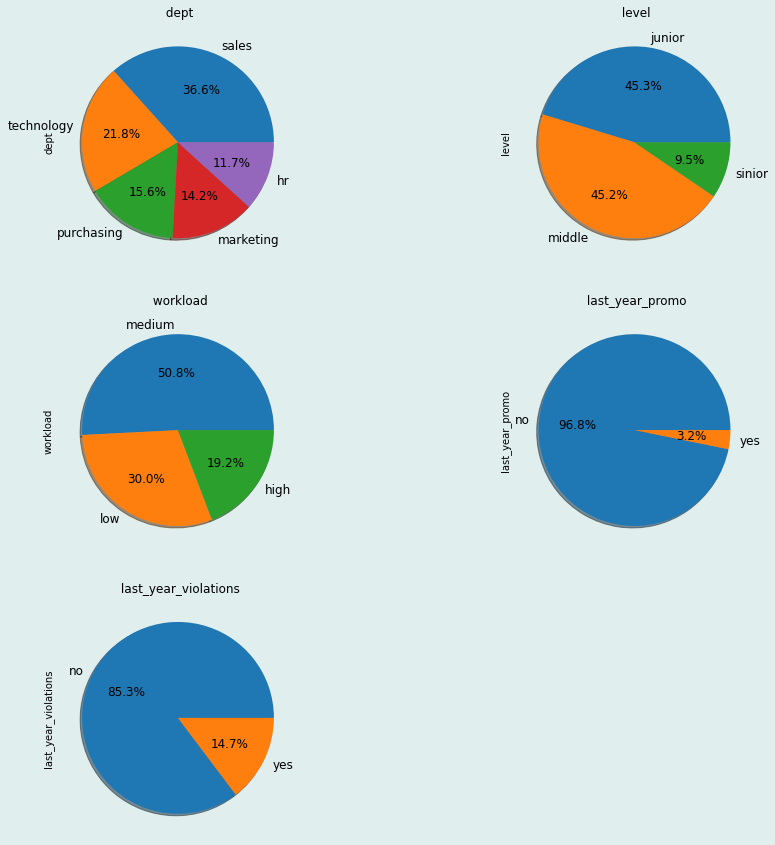

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2)
axe = axes.ravel()
for i, c in enumerate(cat_columns):
    job_satisfaction[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title=' ' +str(c), 
                                      figsize=(15,15),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[5])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

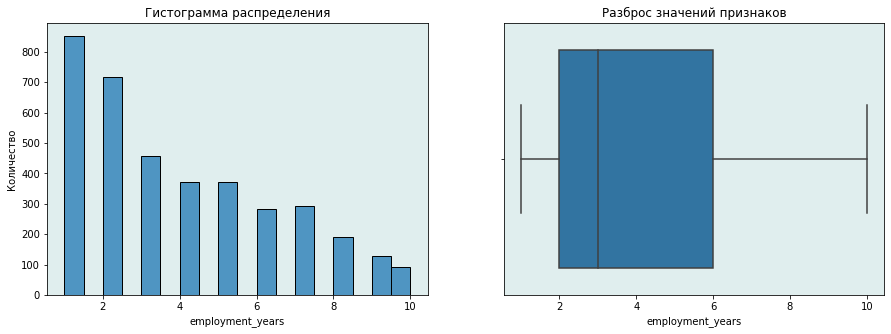

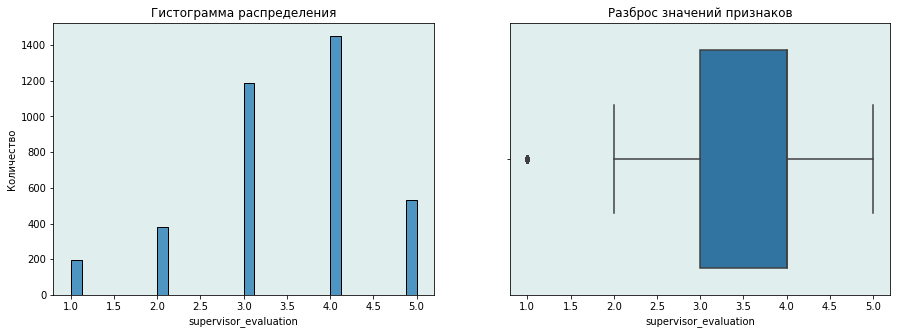

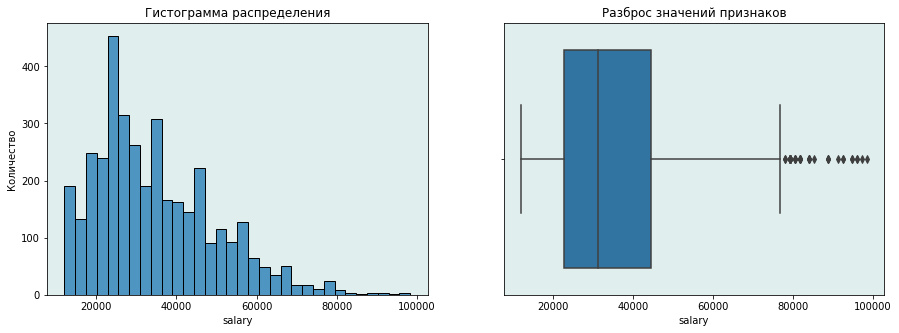

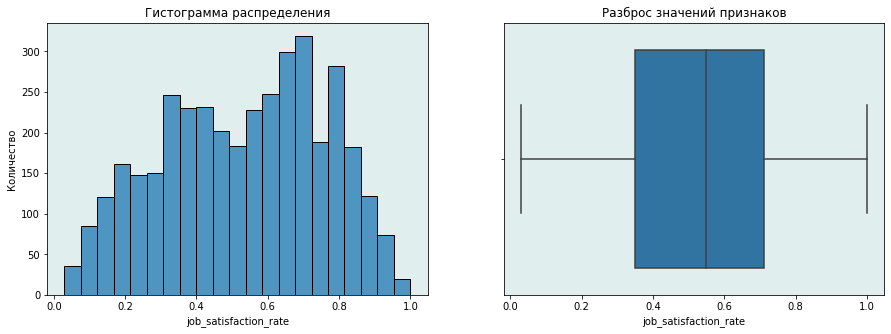

In [18]:
def hist_boxplot(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    sns.histplot(data=df, x=column, ax=axes[0], bins='auto')
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(column)
    axes[0].set_facecolor('#E0EEEE')
    
    sns.boxplot(job_satisfaction[column], ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_facecolor('#E0EEEE')
      
    plt.show()
    
for column in list(all_num_columns):
    hist_boxplot(job_satisfaction, column)

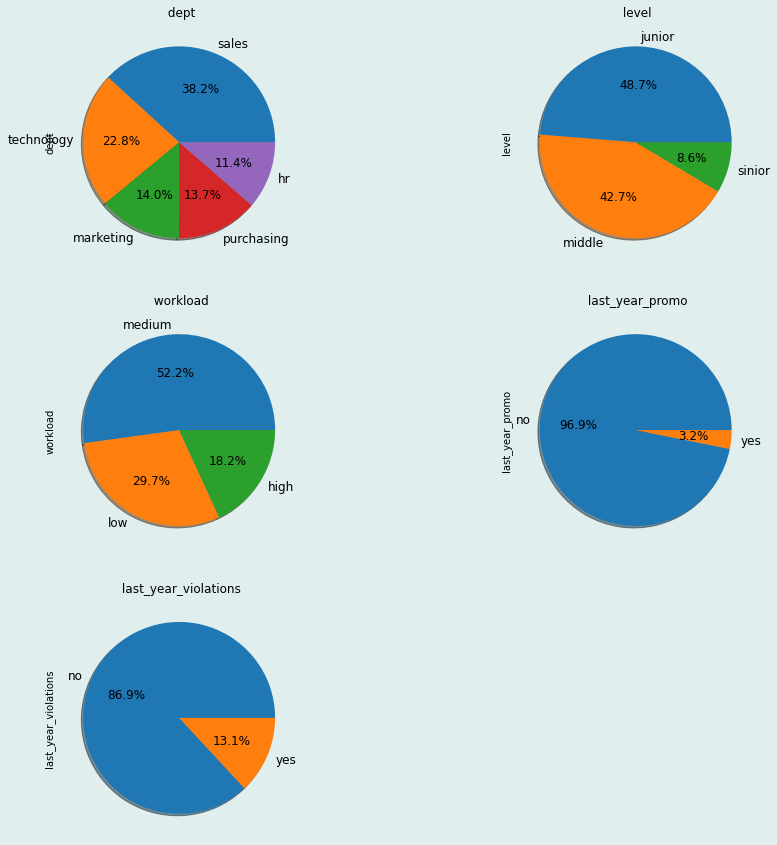

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2)
axe = axes.ravel()
for i, c in enumerate(cat_columns):
    df_test[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title=' ' +str(c), 
                                      figsize=(15,15),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[5])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

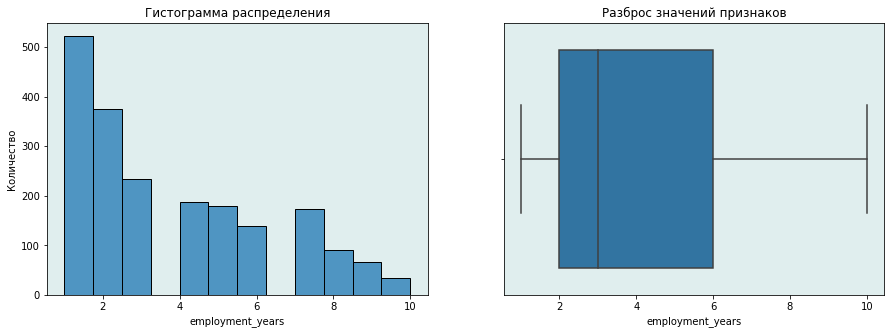

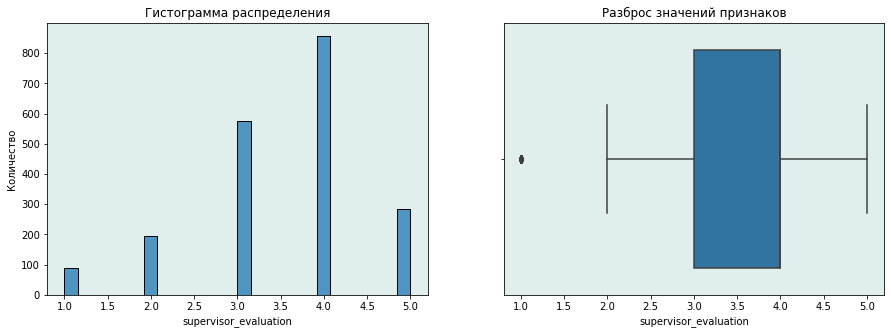

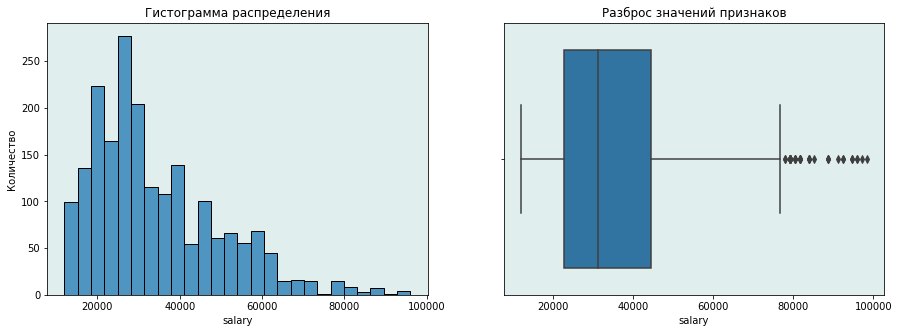

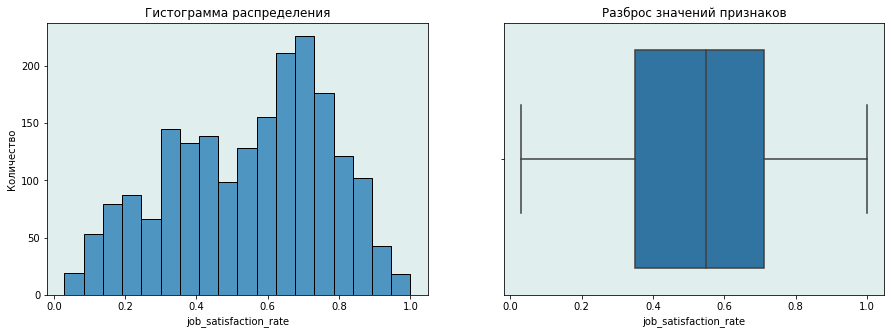

In [20]:
for column in list(all_num_columns):
    hist_boxplot(df_test, column)

**Анализ данных показал, что тренировочный сет и тестовый похожи, признаки распределены примерно одинаково.**

**Категориальные столбцы, кроме `workload`и `level` будем кодировать OneHotEncoder'ом. Количественные - будем масштабировать. Признаки `workload` и `level` - ранговые, их закодируем OrdinalEncoder'ом.**

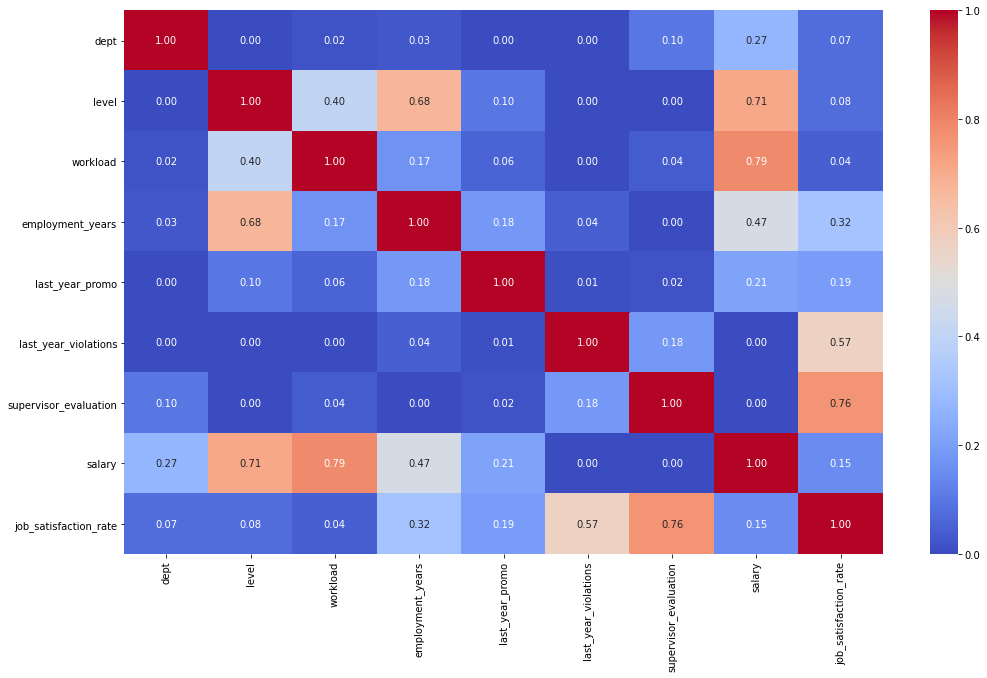

In [21]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(job_satisfaction.phik_matrix(interval_cols=['id', 
                                                        'employment_years', 
                                                        'supervisor_evaluation', 
                                                        'salary', 
                                                        'job_satisfaction_rate']), 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm');

**Коллинеарных и мультиколлинеарных признаков нет.**

## Шаг 4. Подготовка данных

**Объединю шаг 4 и шаг 5 Обучение моделей.**

In [22]:
X_train = job_satisfaction.drop(['job_satisfaction_rate'], axis=1)
X_test = df_test.drop(['job_satisfaction_rate'], axis=1)
y_train = job_satisfaction['job_satisfaction_rate']
y_test = df_test['job_satisfaction_rate']

def smape(y_true, y_pred):
    
    return (100/len(y_true))* (np.sum(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2)))

smape_score = make_scorer(smape, greater_is_better=False)


ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload', 'level']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'hard'], 
                    ['junior', 'middle', 'sinior'],                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor), 
        ('models', LinearRegression())
    ]
)

param_grid = [

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 25),
        'models__max_features': range(1, 25),
        'models__min_samples_leaf': range(1, 25)
    },
    {
        'models': [LinearRegression()],        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
rs = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring=smape_score, n_jobs=-1, random_state=RANDOM_STATE, refit='smape_score')

rs.fit(X_train, y_train)
y_test_pred = rs.predict(X_test)
print(f'Метрика на тестовой выборке: {round(smape(y_test, y_test_pred), 4)}') 
print('Метрика для лучшей модели на кросс-валидационной выборке: ', round((-rs.best_score_), 4))
print('Лучшая модель и её параметры:\n', rs.best_estimator_)
pd.DataFrame(rs.cv_results_)

Метрика на тестовой выборке: 13.6067
Метрика для лучшей модели на кросс-валидационной выборке:  15.4069
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_viol

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020356,0.000803,0.008688,0.000630,14,4,15,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 14, 'models__max_...",-21.124516,-17.279818,-20.938278,-21.088820,-18.802055,-19.846697,1.552249,5
1,0.019517,0.000963,0.008160,0.000279,21,2,12,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 21, 'models__max_...",-22.951471,-23.314506,-27.572105,-21.373195,-25.213620,-24.084980,2.129137,10
2,0.022234,0.002471,0.008541,0.000418,22,16,19,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 22, 'models__max_...",-17.690652,-15.922837,-18.624761,-18.096562,-16.728602,-17.412683,0.969711,4
3,0.022758,0.000941,0.008402,0.000502,3,13,21,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 3, 'models__max_f...",-14.809099,-14.587037,-16.318219,-16.156065,-15.163865,-15.406857,0.704324,1
4,0.018690,0.000219,0.008103,0.000186,17,10,2,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 17, 'models__max_...",-25.065897,-23.656392,-24.377365,-24.222179,-23.102924,-24.084952,0.665527,9
5,0.019458,0.000607,0.008804,0.000722,1,13,2,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 1, 'models__max_f...",-24.872716,-23.563314,-24.481130,-23.984685,-22.923678,-23.965105,0.683583,7
6,0.021785,0.000596,0.008674,0.000247,18,10,19,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 18, 'models__max_...",-17.909922,-15.769937,-18.099115,-18.222962,-16.622613,-17.324910,0.965328,3
7,0.023632,0.001873,0.009624,0.001116,10,16,17,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 10, 'models__max_...",-16.238079,-14.869859,-17.461226,-17.097487,-15.735458,-16.280422,0.932776,2
8,0.019746,0.000294,0.008147,0.000128,9,15,2,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 9, 'models__max_f...",-24.872716,-23.563314,-24.481130,-23.984685,-22.923678,-23.965105,0.683583,7
9,0.020177,0.000715,0.008456,0.000466,12,20,5,"DecisionTreeRegressor(max_depth=21, max_featur...","{'models__min_samples_leaf': 12, 'models__max_...",-19.965537,-18.916768,-20.928583,-20.897813,-20.109176,-20.163575,0.737706,6


**Лучшей моделью стала DecisionTreeRegressor. Метрика — SMAPE для этой модели на тестовой выборке показала результат, удовлетворяющий условию HR-Аналитиков.**

# Задача 2: Предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [23]:
job_quit = pd.read_csv('/datasets/train_quit.csv')
target_quit = pd.read_csv('/datasets/test_target_quit.csv')

## Шаг 2. Предобработка данных

In [24]:
job_quit.info()
print('Количество явных дубликатов:', job_quit.duplicated().sum())
job_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
Количество явных дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [25]:
features.info()
print('Количество явных дубликатов:', features.duplicated().sum())
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
Количество явных дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [26]:
target_quit.info()
print('Количество явных дубликатов:', target_quit.duplicated().sum())
target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
Количество явных дубликатов: 0


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Данные загружены, дубликатов нет, пропуски только в таблице с входными признаками. Их заполним в пайплайне.**

## Шаг 3. Исследовательский анализ данных

- [x] Проведите исследовательский анализ данных.
- [x] Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
- [x] Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [27]:
quit_cat_columns = job_quit.select_dtypes(include='object').columns.tolist()

target_quit['quit'] = target_quit['quit'].replace('no', 0)
target_quit['quit'] = target_quit['quit'].replace('yes', 1)
job_quit['quit'] = job_quit['quit'].replace('no', 0)
job_quit['quit'] = job_quit['quit'].replace('yes', 1)

In [28]:
merge_target_quit = target_quit.merge(target, on='id', how='left')

In [29]:
job_quit = job_quit.set_index('id')
quit_num_columns = job_quit.select_dtypes(exclude='object').columns.tolist()

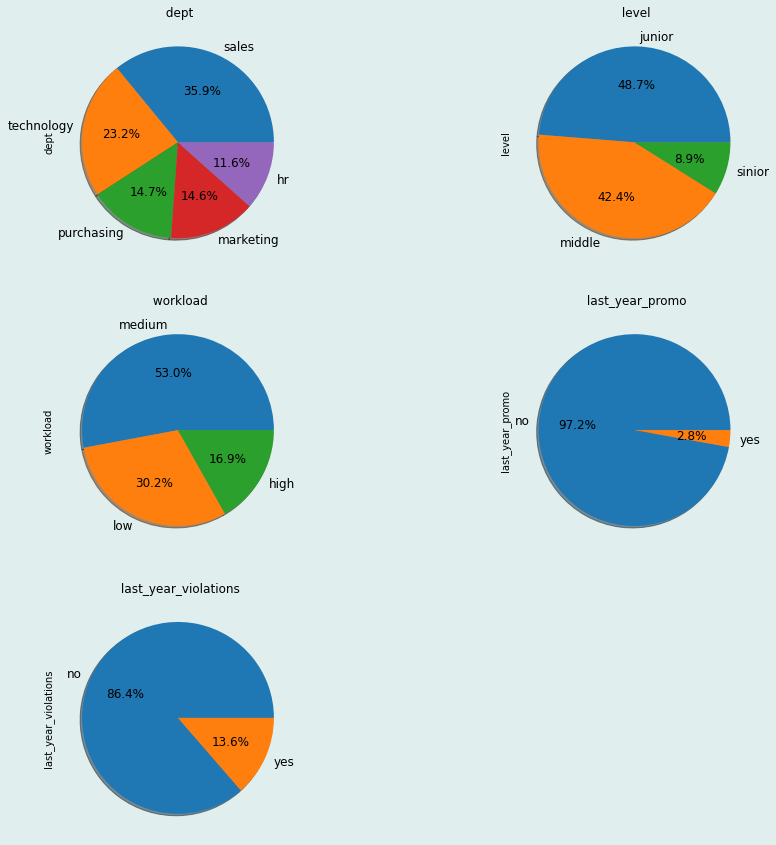

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=2)
axe = axes.ravel()
for i, c in enumerate(quit_cat_columns):
    job_quit[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title=' ' +str(c), 
                                      figsize=(15,15),
                                      fontsize=12,
                                      ax=axe[i])
fig.delaxes(ax=axe[5])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

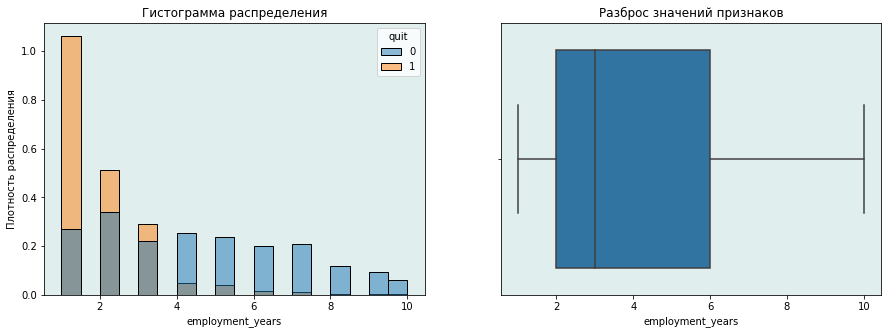

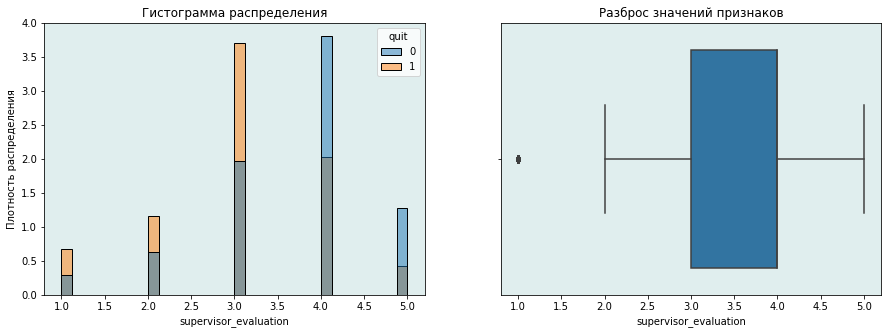

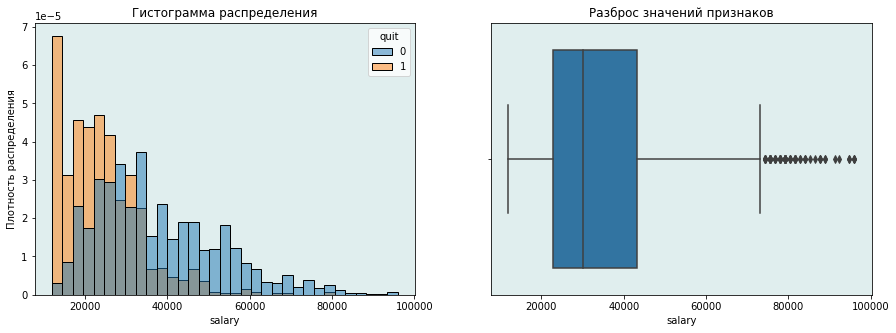

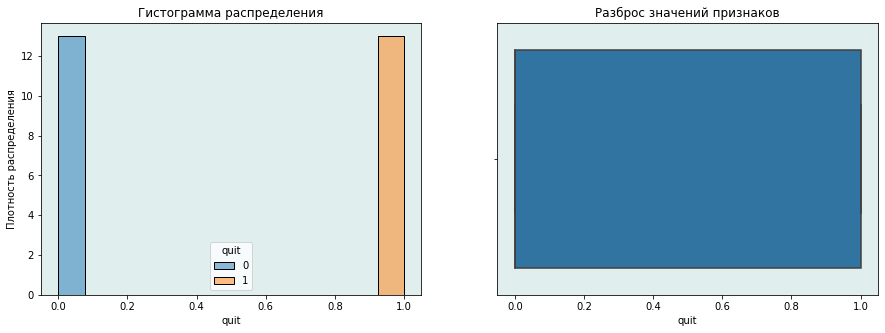

In [31]:
def hist_boxplot(column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    sns.histplot(data=job_quit, x=column, hue='quit', ax=axes[0], bins='auto', stat='density', common_norm=False)
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Плотность распределения')
    axes[0].set_xlabel(column)
    axes[0].set_facecolor('#E0EEEE')
    
    sns.boxplot(job_quit[column], ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_facecolor('#E0EEEE')
      
    plt.show()
    
for column in list(quit_num_columns):
    hist_boxplot(column)

**Чем меньше стаж, тем выше вероятность ухода сотрудника (коллектив, условия труда, зарплата - человек присматривается). Хорошие отношения с начальником тоже очень важны. Ну и кто согласится работать за низкую зарплату? ЗП менее 20 тыс. Это вообще законно?**

**Составим портрет уволившегося сотрудника.**

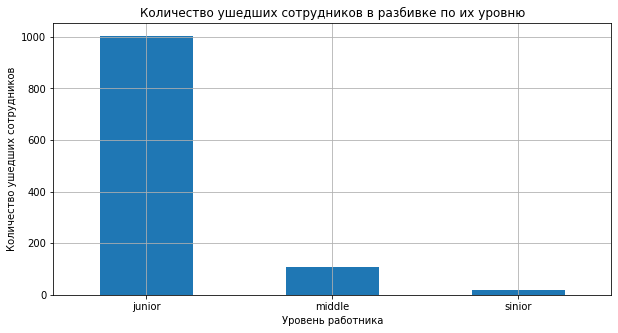

In [32]:
table_pivot = (
    job_quit[job_quit['quit'] == 1]
    .pivot_table(index='level', values='quit', aggfunc='count')
    .sort_values(by='quit', ascending=False)
    .reset_index()
    .plot(x='level', y='quit', kind='bar', grid=True, figsize=(10,5), legend=False)
)
plt.ylabel('Количество ушедших сотрудников')
plt.xlabel('Уровень работника')
plt.xticks(rotation = 0)
plt.title('Количество ушедших сотрудников в разбивке по их уровню');

**Почти все уволившиеся - джуниоры. Посмотрим на уровень зарплат сотрудников с разбивкой по их уровню**

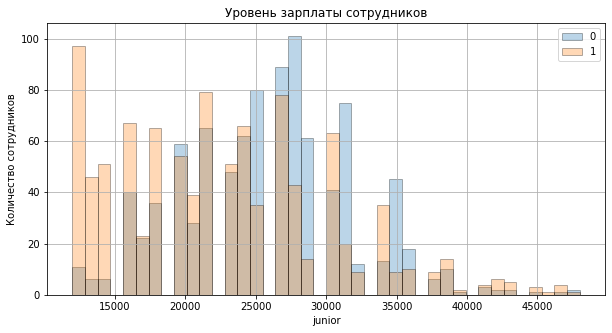

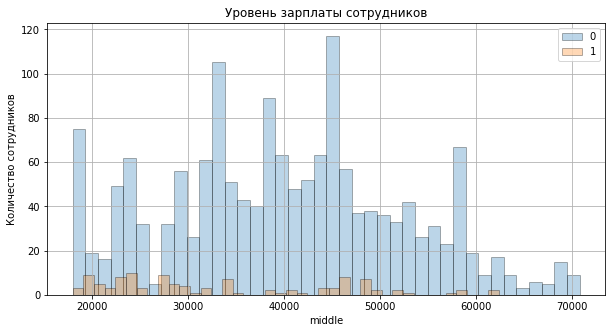

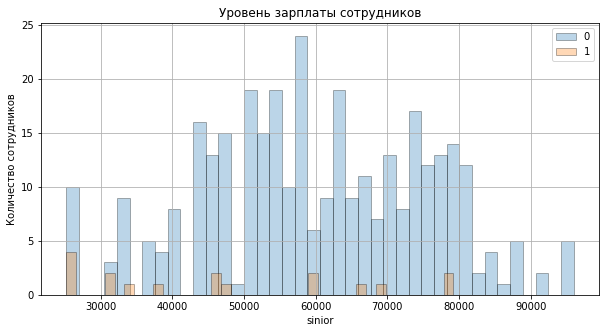

In [33]:
for i in list(['junior', 'middle', 'sinior']):
    sinior = job_quit[job_quit['level']==i]
    sinior.groupby('quit')['salary'].plot(kind='hist', 
                                      bins=40, 
                                      grid=True, 
                                      edgecolor='black', 
                                      legend=True, 
                                      alpha=0.3, 
                                      figsize=(10,5));
    plt.ylabel('Количество сотрудников')
    plt.xlabel(i)
    plt.xticks(rotation = 0)
    plt.title('Уровень зарплаты сотрудников');
    plt.show()

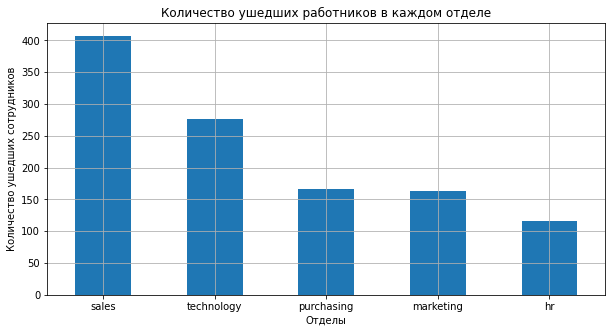

In [34]:
table_pivot = (
    job_quit[job_quit['quit'] == 1]
    .pivot_table(index='dept', values='quit', aggfunc='count')
    .sort_values(by='quit', ascending=False)
    .reset_index()
    .plot(x='dept', y='quit', kind='bar', grid=True, figsize=(10,5), legend=False)
)
plt.ylabel('Количество ушедших сотрудников')
plt.xlabel('Отделы')
plt.xticks(rotation = 0)
plt.title('Количество ушедших работников в каждом отделе');

<AxesSubplot:xlabel='dept,quit'>

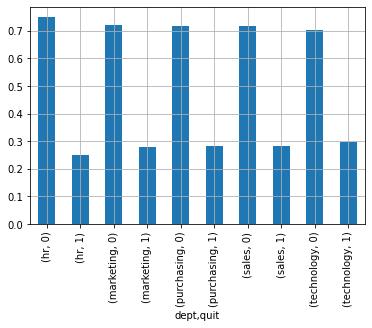

In [35]:
job_quit.groupby(['dept'])['quit'].value_counts(normalize=True).plot(kind='bar', grid=True)

**В процентном соотношении больше всего сотрудники увольняется из отдела `technology`.**

**Скорее всего, я бы тоже не смог долго проработать в отделе продаж или выполяя однообразную работу, стоя у конвеера.**

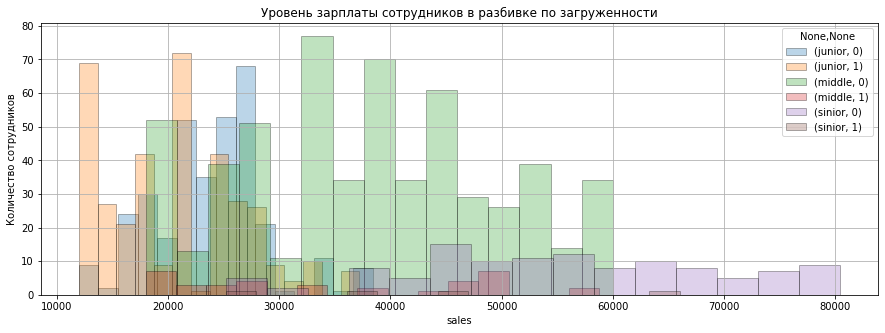

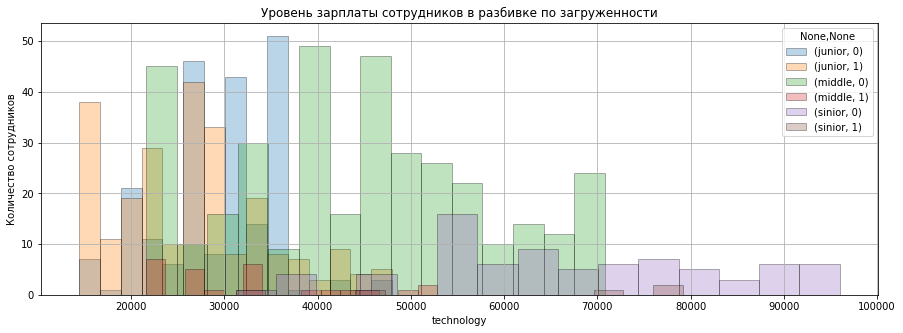

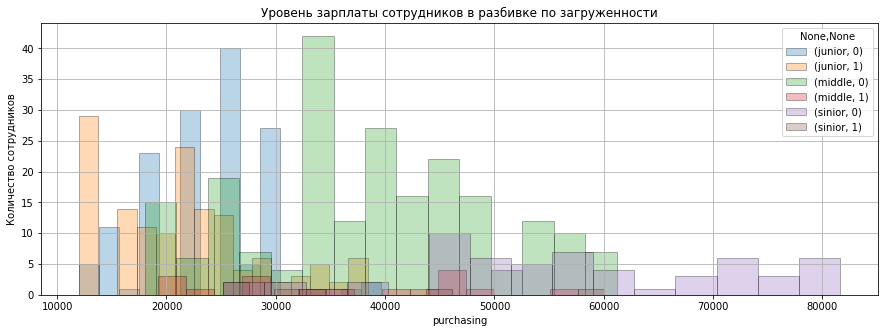

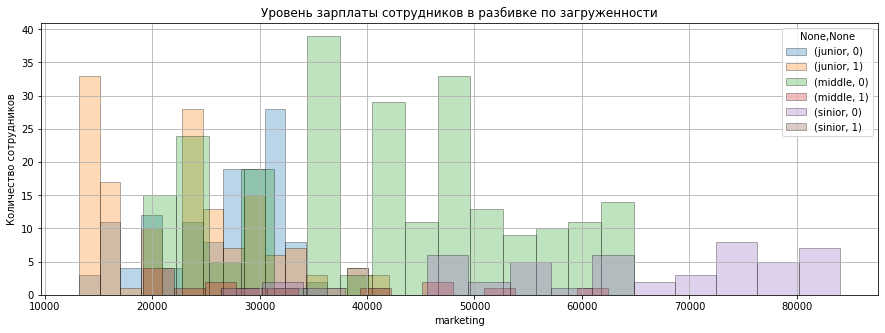

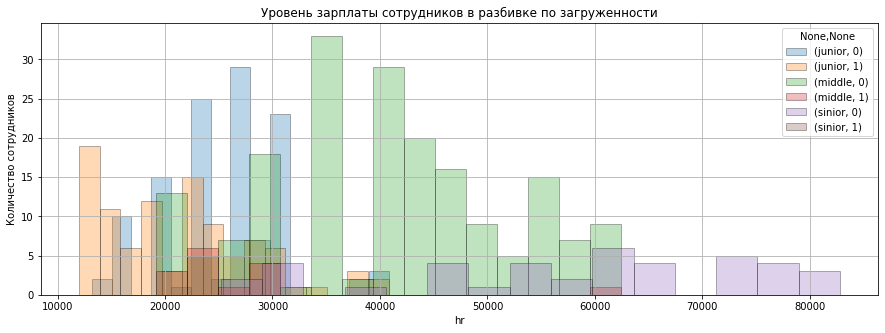

In [36]:
for i in list(['sales', 'technology', 'purchasing', 'marketing', 'hr']):
    sinior = job_quit[job_quit['dept']==i]
    sinior.groupby(['level','quit'])['salary'].plot(kind='hist', 
                                      bins=15, 
                                      grid=True, 
                                      edgecolor='black', 
                                      legend=True, 
                                      alpha=0.3, 
                                      figsize=(15,5));
    plt.ylabel('Количество сотрудников')
    plt.xlabel(i)
    plt.xticks(rotation = 0)
    plt.title('Уровень зарплаты сотрудников в разбивке по загруженности');
    plt.show()

**Труднее всего джунам в продажах, стоит отметить, что из каждого отдела увольняется много сотрудников с зарплатой менее 20000**

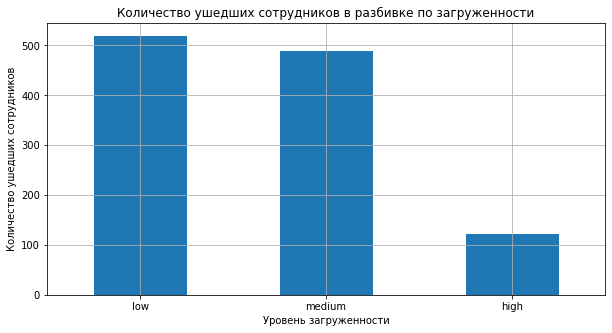

In [37]:
table_pivot = (
    job_quit[job_quit['quit'] == 1]
    .pivot_table(index='workload', values='quit', aggfunc='count')
    .sort_values(by='quit', ascending=False)
    .reset_index()
    .plot(x='workload', y='quit', kind='bar', grid=True, figsize=(10,5), legend=False)
)
plt.ylabel('Количество ушедших сотрудников')
plt.xlabel('Уровень загруженности')
plt.xticks(rotation = 0)
plt.title('Количество ушедших сотрудников в разбивке по загруженности');

**Интересно, реже всего увольнялись люди с высокой загруженностью. Наверное, безделье сильнее изматывает =).**

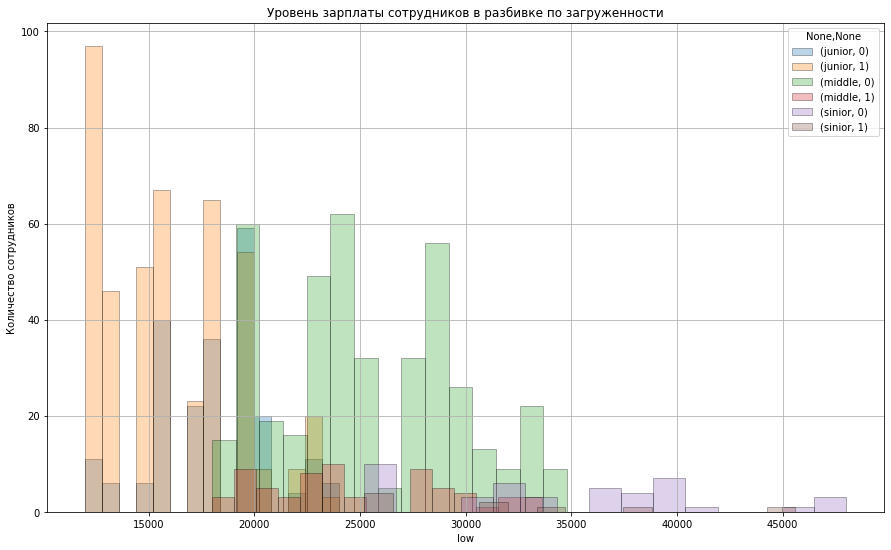

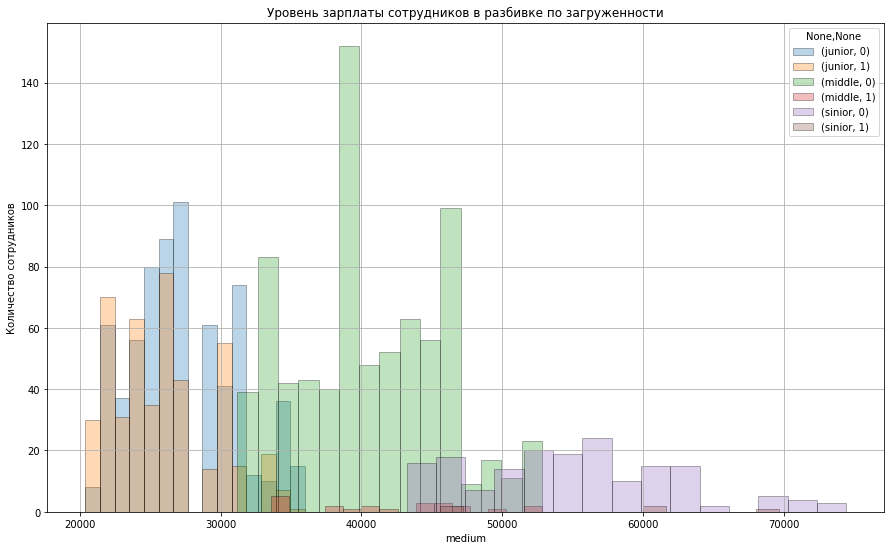

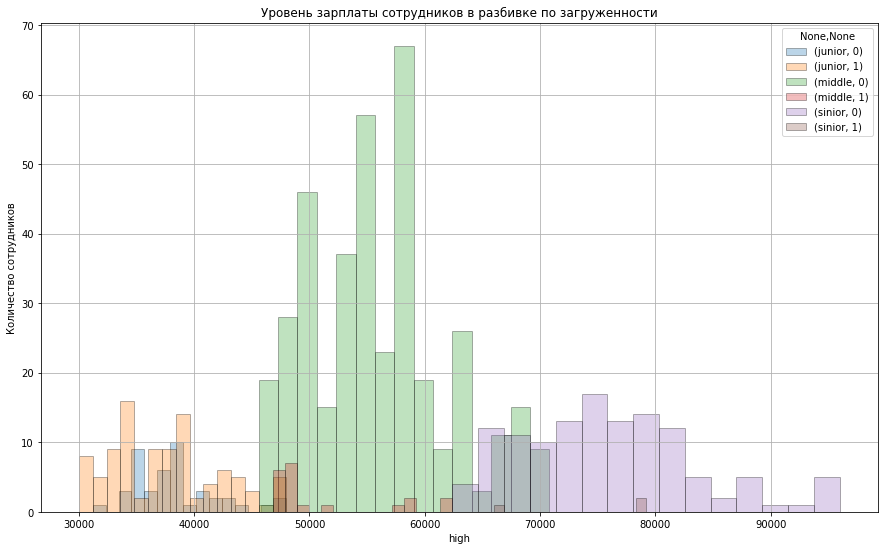

In [38]:
for i in list(['low', 'medium', 'high']):
    sinior = job_quit[job_quit['workload']==i]
    sinior.groupby(['level','quit'])['salary'].plot(kind='hist', 
                                      bins=15, 
                                      grid=True, 
                                      edgecolor='black', 
                                      legend=True, 
                                      alpha=0.3, 
                                      figsize=(15,9));
    plt.ylabel('Количество сотрудников')
    plt.xlabel(i)
    plt.xticks(rotation = 0)
    plt.title('Уровень зарплаты сотрудников в разбивке по загруженности');
    plt.show()

**С Джунами какая то проблема: при малой загруженности, они уходят (видимо, денег мало или хотят набираться опыта, а не штаны просиживать), при высокой загруженности тоже уходят. Только при средней загруженности работников остается больше чем уходит. У миддлов и синиоров соотношение загруженность/зарплата оптимальна.**

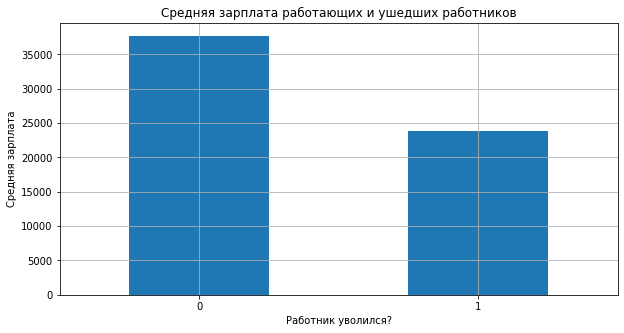

In [39]:
table_pivot = (
    job_quit
    .pivot_table(index='quit', values='salary', aggfunc='mean')    
    .reset_index()
    .plot(x='quit', y='salary', kind='bar', grid=True, figsize=(10,5), legend=False)
)
plt.ylabel('Средняя зарплата')
plt.xlabel('Работник уволился?')
plt.xticks(rotation = 0)
plt.title('Средняя зарплата работающих и ушедших работников');

**В среднем у уволившихся сотрудников зарплата была меньше, чем у оставшихся работать.**

**Что получается в итоге? Чаще всего увольняются Джуниоры из отделов `sales` и `technology`, в основном, это были работники со средней и низкой загруженностью. Средняя зарплата не превышает 25000.**

**Проверим, как уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.**

In [40]:
merge_target_quit.head()

,id,quit,job_satisfaction_rate
0,999029,1,0.35
1,372846,0,0.21
2,726767,0,0.73
3,490105,0,0.62
4,416898,1,0.57


In [41]:
merge_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   quit                   2000 non-null   int64  
 2   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 62.5 KB


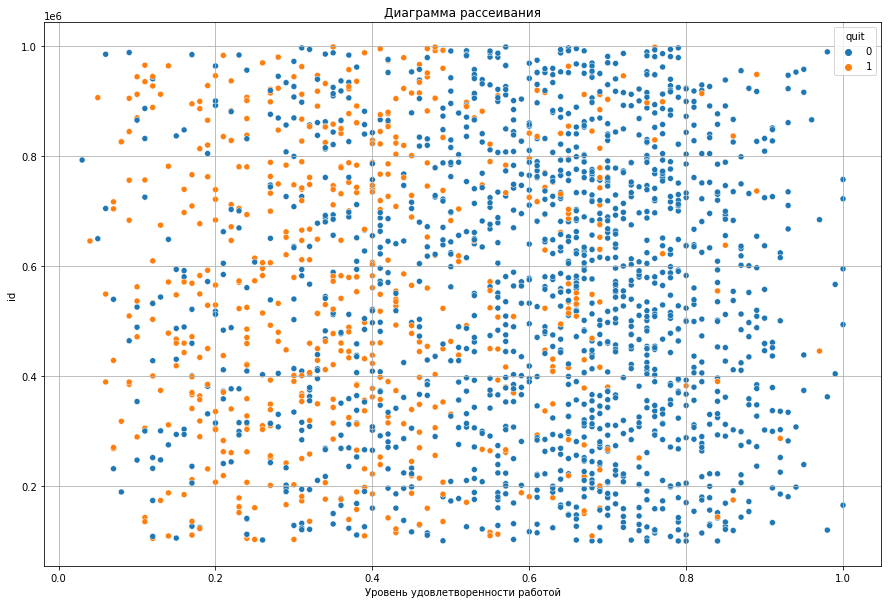

In [42]:
figure(figsize=(15, 10))
sns.scatterplot(data=merge_target_quit, x='job_satisfaction_rate', y='id', hue='quit')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('id')
plt.grid()        
plt.title('Диаграмма рассеивания')
plt.show()

**По диаграмме рассеивания видно, что чем ниже уровень удовлетворенности сотрудника, тем больше вероятность, что он уволится.**

## Шаг 4. Добавление нового входного признака

**Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.**

In [43]:
job_quit['job_satisfaction_rate'] = rs.predict(job_quit).round(2)
features['job_satisfaction_rate'] = rs.predict(features).round(2)

In [44]:
features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.87
1,686555,hr,junior,medium,1,no,no,4,30000,0.68
2,467458,sales,middle,low,5,no,no,4,19200,0.69
3,418655,sales,middle,low,6,no,no,4,19200,0.71
4,789145,hr,middle,medium,5,no,no,5,40800,0.81


In [45]:
df_test_1 = features.merge(target_quit, on='id', how='left')
df_test_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.87,0
1,686555,hr,junior,medium,1,no,no,4,30000,0.68,0
2,467458,sales,middle,low,5,no,no,4,19200,0.69,0
3,418655,sales,middle,low,6,no,no,4,19200,0.71,0
4,789145,hr,middle,medium,5,no,no,5,40800,0.81,0


## Шаг 5. Подготовка данных

**Объединю подготовку данных и обучение модели** 

In [46]:
X_train = job_quit.drop(['quit'], axis=1)
X_test = df_test_1.drop(['quit'], axis=1)
y_train = job_quit['quit']
y_test = df_test_1['quit']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload', 'level']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'hard'], 
                    ['junior', 'middle', 'sinior'],                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor), 
        ('models', LogisticRegression())
    ]
)

param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 25),
        'models__max_features': range(1, 25),
        'models__min_samples_leaf': range(1, 25)
    },    

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },


    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
rs_1 = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE)

rs_1.fit(X_train, y_train)
y_test_pred = rs_1.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred[:,1]), 4)}') 
print('Метрика ROC-AUC для лучшей модели на кросс-валидационной выборке: ', round((rs_1.best_score_), 4))
print('Лучшая модель и её параметры:\n', rs_1.best_estimator_)
pd.DataFrame(rs_1.cv_results_)

Метрика ROC-AUC на тестовой выборке: 0.9247
Метрика ROC-AUC для лучшей модели на кросс-валидационной выборке:  0.931
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020546,0.000293,0.009238,0.000741,14,4,15,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 14, 'models__max_...",0.927830,0.915919,0.923114,0.921950,0.939294,0.925621,0.007820,4
1,0.021808,0.003118,0.009812,0.001691,21,2,12,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 21, 'models__max_...",0.918346,0.925762,0.919456,0.910946,0.928047,0.920511,0.006028,6
2,0.021893,0.000457,0.008697,0.000317,22,16,19,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 22, 'models__max_...",0.922643,0.928827,0.923414,0.926590,0.943630,0.929021,0.007635,2
3,0.022685,0.000952,0.008681,0.000520,3,13,21,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 3, 'models__max_f...",0.910814,0.923938,0.906297,0.902335,0.921884,0.913054,0.008509,7
4,0.019486,0.000595,0.008678,0.000258,17,10,2,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 17, 'models__max_...",0.886446,0.867567,0.850340,0.881961,0.894669,0.876197,0.015637,10
5,0.020459,0.000938,0.008696,0.000163,1,13,2,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 1, 'models__max_f...",0.874141,0.874748,0.870070,0.885896,0.902393,0.881450,0.011715,8
6,0.023291,0.002565,0.008779,0.000178,18,10,19,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 18, 'models__max_...",0.921805,0.927212,0.925804,0.937059,0.943110,0.930998,0.007865,1
7,0.022744,0.000378,0.009210,0.000261,10,16,17,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 10, 'models__max_...",0.915737,0.931525,0.916966,0.927666,0.935956,0.925570,0.007980,5
8,0.019767,0.000648,0.008723,0.000365,9,15,2,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 9, 'models__max_f...",0.874141,0.874748,0.870070,0.885896,0.902393,0.881450,0.011715,8
9,0.020343,0.000343,0.008349,0.000100,12,20,5,"DecisionTreeClassifier(max_depth=19, max_featu...","{'models__min_samples_leaf': 12, 'models__max_...",0.923393,0.925283,0.921260,0.926143,0.941830,0.927582,0.007320,3


**Снова победило `Дерево решений`. Метрика `roc-auc` показала неплохое значение, которое удовлетворит компанию «Работа с заботой».**

## Шаг 7. Выводы

**Лучшей моделью получилось `Дерево решений` (DecisionTreeClassifier) данная модель имеет ряд преимуществ:**
 - Поддерживает работу с входными переменными разных (смешанных) типов; 
 - Обрабатывает данные с пропущенными значениями;
 - Устойчива к выбросам;
 - Поддерживает работу с большими выборками;
 - Возможность интерпретации построенного решающего правила.

## Общий вывод

К нам обратились HR-аналитики компании «Работа с заботой». Для того, чтобы избежать финансовых потерь и оттока сотрудников, HR-аналитики делают ставку на машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Нам было поручено решить две задачи. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для выполнения первой задачи была проведена предобработка и исследовательский анализ данных. Это нужно для понимания какие модели эффективнее всего покажут себя и какими инструментами нам предстоит воспользоваться для настройки выбранных моделей. Метрикой качества модели была выбрана `SMAPE (Симметричная средняя абсолютная процентная ошибка)`. В итоге, на выходе у нас получилась модель Дерево решений и значение метрики меньше 15, что удовлетворяет условию задачи.

Условием выполнения второй задачи была модель, предсказывающая уход сотрудника из компании с метрикой оценки качества более 0.91. Мы проделали все те же шаги, что и в первой задаче. И снова лучшей оказалась модель `Дерево решений`. Так же был составлен портрет уволившегося сотрудника. Было установлено, что чаще всего увольняются Джуниоры из отделов `sales` и `technology`, в основном, это были работники со средней и низкой загруженностью. Средняя зарплата не превышает 25000.

Графики показывают, что у компании «Работа с заботой» проблема с текучкой персонала категории Junior. Было отмечено, что для них плохо подобрано соотношение `зарплата/загруженность`. Возможно стоит обратить на это внимание. Также напрашивается вывод об увеличении нижнего порога зарплат. Мало кто желает работать зарплату менее 20000.